# Feature Importance & Ablation Study: Wine Quality Dataset

**Research Question:** "Which features matter and why? An ablation study on the Wine Quality dataset."

**Authoren:** Katrin Nguyen & Nico Loss

## 1. Setup & Imports <a id='setup'></a>

In [28]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score
)

# Feature selection methods
from sklearn.feature_selection import (
    mutual_info_classif,
    f_classif
)
from sklearn.inspection import permutation_importance

# Report generation
from ydata_profiling import ProfileReport

# For data fetching
from ucimlrepo import fetch_ucirepo

from scipy import stats

warnings.filterwarnings('ignore')

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
TEST_SIZE = 0.20
CV_FOLDS = 5

Path("Reports").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful")

✓ All imports successful


## 2. Data Loading & Exploration <a id='data-loading'></a>

### 2.1 Load Dataset
Link: https://archive.ics.uci.edu/dataset/186/wine+quality

In [2]:
# Fetch dataset from UCI repository
print("Fetching Wine Quality dataset from UCI repository...")
wine_quality = fetch_ucirepo(id=186)

# Extract features and target
X = wine_quality.data.features
y = wine_quality.data.targets

# Combine for easier manipulation
df = pd.concat([X, y], axis=1)

print(f"\n✓ Dataset loaded successfully")
print(f"  - Shape: {df.shape}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Samples: {len(df)}")

print("\n" + "="*50)
print("VARIABLE INFORMATION")
print("="*50)
print(wine_quality.variables)

Fetching Wine Quality dataset from UCI repository...

✓ Dataset loaded successfully
  - Shape: (6497, 12)
  - Features: 11
  - Samples: 6497

VARIABLE INFORMATION
                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Oth

## 3. Data Preprocessing <a id='preprocessing'></a>

### 3.1 Missing Values Check

In [3]:
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")
print("\n✓ Dataset is clean - no missing values")

Missing Values:
No missing values

✓ Dataset is clean - no missing values


### 3.2 Train/Validation/Test Split

In [4]:
print("\n" + "="*50)
print("TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)")
print("="*50)

# First split: separate test set (20%)
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Second split: separate train (60%) and validation (20% of total = 25% of temp)
df_train, df_val = train_test_split(df_temp, test_size=0.25, random_state=42)

print(f"Training set (raw): {len(df_train)} samples")
print(f"Validation set (raw): {len(df_val)} samples")
print(f"Test set (raw): {len(df_test)} samples")


TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)
Training set (raw): 3897 samples
Validation set (raw): 1300 samples
Test set (raw): 1300 samples


### 3.3 Report Generation

In [5]:
profile = ProfileReport(df_train, title="Wine Quality Dataset Report", explorative=True)
profile.to_file("Reports/wine_quality_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 50.03it/s]


### 3.4 Outlier-Behandlung

In [6]:
print("\n" + "="*60)
print("OUTLIER HANDLING")
print("="*60)

# 1. Definieren der Features, die geprüft werden sollen
TARGET_COL = 'quality'
feature_names = [col for col in df_train.columns if col != TARGET_COL]
factor = 3.0

print(f"Berechne Outlier-Grenzen (IQR-Faktor={factor}) aus df_train...")

# 2. Outlier-Grenzen aus den Trainingsdaten berechnen
bounds = {}
for feature in feature_names:
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    bounds[feature] = (lower_bound, upper_bound)

# 3. Funktion, um Zeilen basierend auf den gelernten Grenzen zu entfernen
def remove_outliers_with_bounds(df, bounds_dict):
    df_clean = df.copy()
    # Maske ist initial True für alle Zeilen
    mask = pd.Series(True, index=df_clean.index)

    # Filtere alle Features: Eine Zeile wird entfernt, wenn sie *bei irgendeinem* Feature
    # außerhalb der Grenzen liegt.
    for feature, (lower, upper) in bounds_dict.items():
        # Behalte Zeilen, die INNERHALB der Grenzen liegen (mask & (Bedingung))
        mask = mask & (df_clean[feature] >= lower) & (df_clean[feature] <= upper)

    mask = mask & ~df_clean['quality'].isin([3, 9]) # Elemente mit Quality 3 & 9 entfernen aufgrund der geringen Anzahl

    removed_count = len(df_clean) - mask.sum()
    return df_clean[mask], removed_count

# 4. Wende die gleichen Grenzen auf alle drei Datensätze an
print("\nWende Grenzen auf df_train, df_val und df_test an...")

len_train_orig = len(df_train)
df_train, removed_train = remove_outliers_with_bounds(df_train, bounds)
print(f"  Trainingsset:   {len_train_orig} -> {len(df_train)} (Entfernt: {removed_train})")

len_val_orig = len(df_val)
df_val, removed_val = remove_outliers_with_bounds(df_val, bounds)
print(f"  Validierungsset: {len_val_orig} -> {len(df_val)} (Entfernt: {removed_val})")

len_test_orig = len(df_test)
df_test, removed_test = remove_outliers_with_bounds(df_test, bounds)
print(f"  Testset:       {len_test_orig} -> {len(df_test)} (Entfernt: {removed_test})")

total_orig = len_train_orig + len_val_orig + len_test_orig
total_removed = removed_train + removed_val + removed_test

print(f"\nInsgesamt entfernt: {total_removed} Samples ({(total_removed / total_orig * 100):.2f}%)")


OUTLIER HANDLING
Berechne Outlier-Grenzen (IQR-Faktor=3.0) aus df_train...

Wende Grenzen auf df_train, df_val und df_test an...
  Trainingsset:   3897 -> 3723 (Entfernt: 174)
  Validierungsset: 1300 -> 1231 (Entfernt: 69)
  Testset:       1300 -> 1219 (Entfernt: 81)

Insgesamt entfernt: 324 Samples (4.99%)


### 3.5 Prepare Feature and Target

In [7]:
print("\n" + "="*50)
print("FEATURE AND TARGET PREPARATION")
print("="*50)

# Zielvariable (Target)
TARGET_COL = 'quality'

# Extract features and targets
X_train = df_train.drop(TARGET_COL, axis=1)
y_train = df_train['quality']

X_val = df_val.drop(TARGET_COL, axis=1)
y_val = df_val['quality']

X_test = df_test.drop(TARGET_COL, axis=1)
y_test = df_test['quality']

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


FEATURE AND TARGET PREPARATION
X_train shape: (3723, 11)
X_val shape: (1231, 11)
X_test shape: (1219, 11)


### 3.6 Feature Scaling

In [8]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Feature Scaling Complete (StandardScaler)")
print(f"  Train mean: {X_train_scaled.mean().mean():.6f}")
print(f"  Train std:  {X_train_scaled.std().mean():.6f}")

Feature Scaling Complete (StandardScaler)
  Train mean: -0.000000
  Train std:  1.000134


## 4.0 Explorative Data Analysis

In [9]:
print("First 5 rows:")
display(df_train.head())

print("\nDataset Statistics:")
display(df_train.describe())

print("\nData Types and Missing Values:")
info_df = pd.DataFrame({
    'Column': df_train.columns,
    'Type': df_train.dtypes,
    'Non-Null': df_train.count(),
    'Null': df_train.isnull().sum(),
    'Null %': (df_train.isnull().sum() / len(df_train) * 100).round(2)
})
display(info_df)

First 5 rows:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
5130,6.4,0.28,0.44,7.1,0.048,49.0,179.0,0.99528,3.15,0.48,9.2,5
3064,7.0,0.20,0.74,0.8,0.044,19.0,163.0,0.99310,3.46,0.53,10.2,5
4040,7.2,0.20,0.28,1.6,0.028,13.0,168.0,0.99203,3.17,1.06,11.5,6
2950,6.5,0.37,0.33,3.9,0.027,40.0,130.0,0.99060,3.28,0.39,12.7,7
4221,6.6,0.26,0.21,2.9,0.026,48.0,126.0,0.99089,3.22,0.38,11.3,7



Dataset Statistics:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3723.000000,3723.000000,3723.000000,3723.000000,3723.000000,3723.000000,3723.000000,3723.000000,3723.000000,3723.000000,3723.000000,3723.000000
mean,7.111550,0.327270,0.315356,5.493258,0.051684,30.967365,117.756648,0.994555,3.219224,0.524053,10.494525,5.828364
std,1.099253,0.151389,0.135176,4.711676,0.020426,16.963906,54.804538,0.002876,0.156853,0.131311,1.191069,0.849712
min,3.900000,0.080000,0.000000,0.600000,0.009000,2.000000,6.000000,0.987110,2.740000,0.220000,8.000000,4.000000
25%,6.400000,0.220000,0.250000,1.800000,0.038000,18.000000,84.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,6.900000,0.280000,0.310000,3.200000,0.046000,29.000000,120.000000,0.994720,3.210000,0.500000,10.300000,6.000000
75%,7.600000,0.390000,0.390000,8.250000,0.060000,42.000000,157.000000,0.996800,3.320000,0.600000,11.300000,6.000000
max,11.600000,0.935000,0.800000,22.000000,0.142000,108.000000,344.000000,1.002600,3.900000,1.100000,14.200000,8.000000



Data Types and Missing Values:


,Column,Type,Non-Null,Null,Null %
fixed_acidity,fixed_acidity,float64,3723,0,0.0
volatile_acidity,volatile_acidity,float64,3723,0,0.0
citric_acid,citric_acid,float64,3723,0,0.0
residual_sugar,residual_sugar,float64,3723,0,0.0
chlorides,chlorides,float64,3723,0,0.0
free_sulfur_dioxide,free_sulfur_dioxide,float64,3723,0,0.0
total_sulfur_dioxide,total_sulfur_dioxide,float64,3723,0,0.0
density,density,float64,3723,0,0.0
pH,pH,float64,3723,0,0.0
sulphates,sulphates,float64,3723,0,0.0


### 4.3 Correlation Analysis

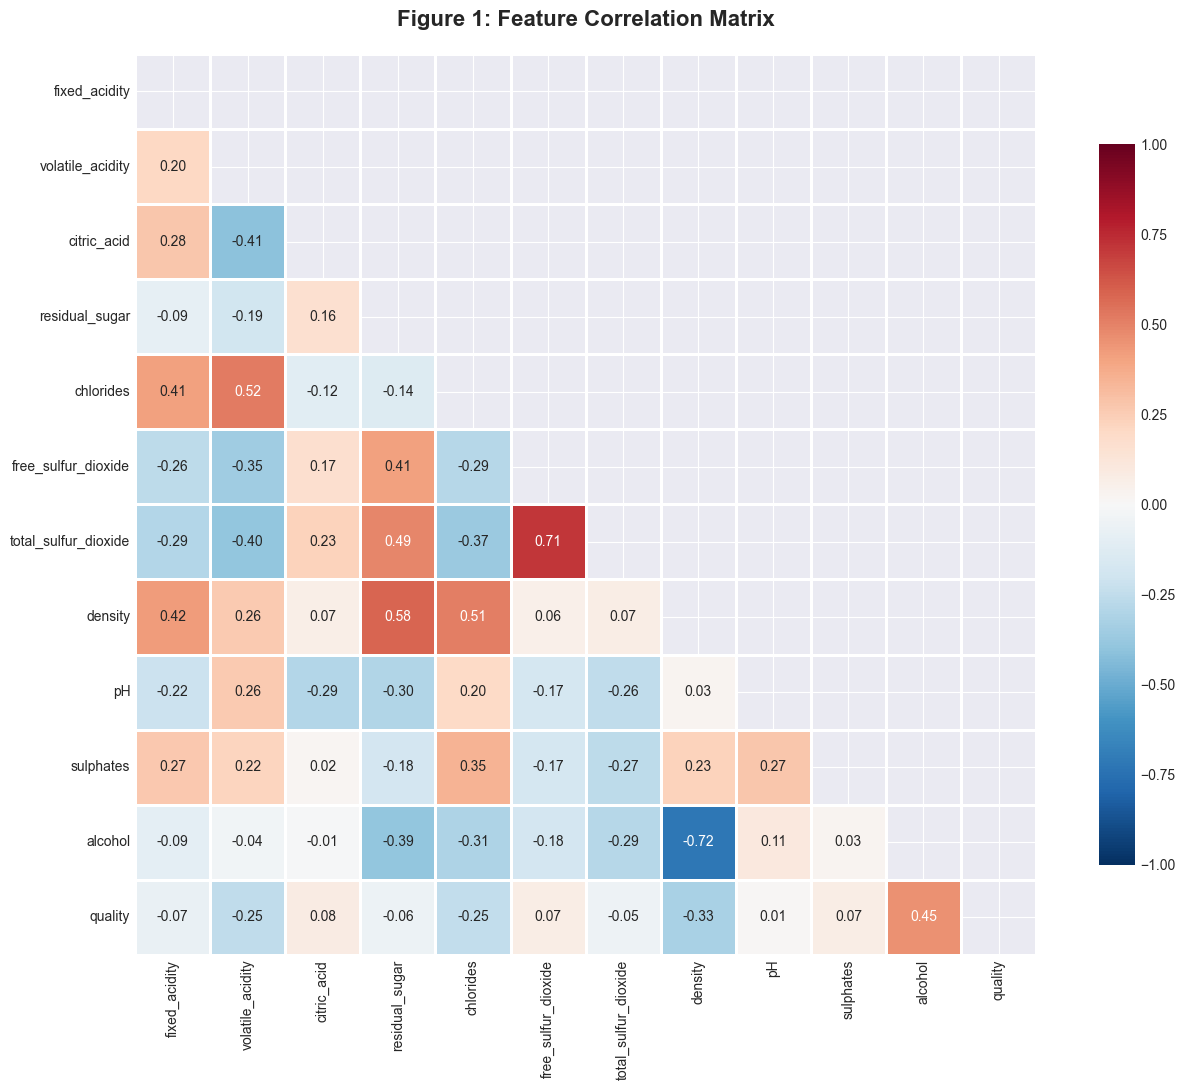


Correlations with Quality:
alcohol                 0.453874
citric_acid             0.079068
free_sulfur_dioxide     0.074858
sulphates               0.070505
pH                      0.012889
total_sulfur_dioxide   -0.053428
residual_sugar         -0.057553
fixed_acidity          -0.072722
chlorides              -0.248973
volatile_acidity       -0.254015
density                -0.326655
Name: quality, dtype: float64


In [10]:
correlation_matrix = df_train.corr()

plt.figure(figsize=(14, 11))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Figure 1: Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/figure1_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelations with Quality:")
print(correlation_matrix['quality'].drop('quality').sort_values(ascending=False))

## 5. Baseline Model

### 5.1 Train and Evaluate Baseline Model

In [11]:
sampling_strategy = {
    4: 200,
    8: 200
}

sampler = SMOTEENN(random_state=RANDOM_STATE,
                   sampling_strategy=sampling_strategy,
                   smote=SMOTE(random_state=RANDOM_STATE, k_neighbors=3))

param_grid = {
    'max_depth': [5, 6, 7],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [8, 10, 12, 14],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [80, 100, 120]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Erstellen der imbalanced-learn Pipeline
pipe = ImbPipeline([
    ('sampler', sampler),
    ('rf', rf)
])

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=CV_FOLDS, n_jobs=-1, verbose=2, return_train_score=True)

# 3. Modell trainieren
grid_search.fit(X_train_scaled, y_train)

print(f"\nBeste Parameter nach GridSearchCV: {grid_search.best_params_}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Beste Parameter nach GridSearchCV: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 80}


In [12]:
baseline_model = RandomForestClassifier(**grid_search.best_params_)
baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_val_pred = baseline_model.predict(X_val_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

# Metrics
baseline_metrics = {
    'Training Accuracy': accuracy_score(y_train, y_train_pred),
    'Validation Accuracy': accuracy_score(y_val, y_val_pred),
    'Test Accuracy': accuracy_score(y_test, y_test_pred),
    'Validation F1': f1_score(y_val, y_val_pred, average='weighted'),
    'Validation Precision': precision_score(y_val, y_val_pred, average='weighted', zero_division=0),
    'Validation Recall': recall_score(y_val, y_val_pred, average='weighted'),
    'Test F1': f1_score(y_test, y_test_pred, average='weighted'),
    'Test Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
    'Test Recall': recall_score(y_test, y_test_pred, average='weighted')
}

# Cross-validation
cv_scores = cross_val_score(baseline_model, X_train_scaled, y_train, 
                            cv=CV_FOLDS, scoring='accuracy')
baseline_metrics['CV Mean'] = cv_scores.mean()
baseline_metrics['CV Std'] = cv_scores.std()

print("\n" + "="*70)
print("TABLE 2: BASELINE PERFORMANCE (REGULARIZED MODEL)")
print("="*70)
for metric, value in baseline_metrics.items():
    print(f"{metric:25s}: {value:.4f}")

# Check overfitting
train_val_gap = baseline_metrics['Training Accuracy'] - baseline_metrics['Validation Accuracy']
print(f"\n{'='*70}")
print(f"OVERFITTING CHECK")
print(f"{'='*70}")
print(f"Train-Validation Gap: {train_val_gap:.4f} ({train_val_gap*100:.2f}%)")

if train_val_gap < 0.05:
    print("✓✓ EXCELLENT: Gap < 5% - No overfitting!")
elif train_val_gap < 0.10:
    print("✓ GOOD: Gap < 10% - Acceptable generalization")
elif train_val_gap < 0.15:
    print("⚠ WARNING: Gap 10-15% - Slight overfitting")
else:
    print("❌ PROBLEM: Gap > 15% - Significant overfitting")

# Save
pd.DataFrame([baseline_metrics]).to_csv('figures/table2_baseline_performance.csv', index=False, sep=";")
print("\n✓ Saved to figures/table2_baseline_performance.csv")


TABLE 2: BASELINE PERFORMANCE (REGULARIZED MODEL)
Training Accuracy        : 0.6656
Validation Accuracy      : 0.6052
Test Accuracy            : 0.5865
Validation F1            : 0.5705
Validation Precision     : 0.5593
Validation Recall        : 0.6052
Test F1                  : 0.5570
Test Precision           : 0.5567
Test Recall              : 0.5865
CV Mean                  : 0.5780
CV Std                   : 0.0221

OVERFITTING CHECK
Train-Validation Gap: 0.0604 (6.04%)
✓ GOOD: Gap < 10% - Acceptable generalization

✓ Saved to figures/table2_baseline_performance.csv


### 5.2 Detailed Cross-Validation Analyse

In [13]:
print("="*80)
print("DETAILLIERTE CROSS-VALIDATION ANALYSE")
print("="*80)

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}

# Perform cross-validation with multiple metrics
print(f"\nDurchführung der {CV_FOLDS}-Fold Cross-Validation...\n")
cv_results = cross_validate(
    baseline_model,
    X_train_scaled,
    y_train,
    cv=CV_FOLDS,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Create DataFrame for better visualization
cv_results_df = pd.DataFrame({
    'Fold': range(1, CV_FOLDS + 1),
    'Train Accuracy': cv_results['train_accuracy'],
    'Test Accuracy': cv_results['test_accuracy'],
    'Test Precision': cv_results['test_precision_weighted'],
    'Test Recall': cv_results['test_recall_weighted'],
    'Test F1-Score': cv_results['test_f1_weighted']
})

print("\nErgebnisse pro Fold:")
print("="*80)
display(cv_results_df.round(4))

# Calculate statistics
print("\n\nZusammenfassende Statistiken:")
print("="*80)

summary_stats = pd.DataFrame({
    'Metrik': ['Train Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score'],
    'Mittelwert': [
        cv_results['train_accuracy'].mean(),
        cv_results['test_accuracy'].mean(),
        cv_results['test_precision_weighted'].mean(),
        cv_results['test_recall_weighted'].mean(),
        cv_results['test_f1_weighted'].mean()
    ],
    'Std. Abweichung': [
        cv_results['train_accuracy'].std(),
        cv_results['test_accuracy'].std(),
        cv_results['test_precision_weighted'].std(),
        cv_results['test_recall_weighted'].std(),
        cv_results['test_f1_weighted'].std()
    ],
    'Min': [
        cv_results['train_accuracy'].min(),
        cv_results['test_accuracy'].min(),
        cv_results['test_precision_weighted'].min(),
        cv_results['test_recall_weighted'].min(),
        cv_results['test_f1_weighted'].min()
    ],
    'Max': [
        cv_results['train_accuracy'].max(),
        cv_results['test_accuracy'].max(),
        cv_results['test_precision_weighted'].max(),
        cv_results['test_recall_weighted'].max(),
        cv_results['test_f1_weighted'].max()
    ]
})

display(summary_stats.round(4))

# Calculate variance between train and test (overfitting indicator)
train_test_gap = cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean()
print(f"\n\nÜberfitting-Analyse:")
print("="*80)
print(f"Durchschnittlicher Train-Test Gap: {train_test_gap:.4f} ({train_test_gap*100:.2f}%)")

if train_test_gap < 0.05:
    print("✓✓ AUSGEZEICHNET: Gap < 5% - Kein Overfitting!")
elif train_test_gap < 0.10:
    print("✓ GUT: Gap < 10% - Akzeptable Generalisierung")
elif train_test_gap < 0.15:
    print("⚠ WARNUNG: Gap 10-15% - Leichtes Overfitting")
else:
    print("❌ PROBLEM: Gap > 15% - Signifikantes Overfitting")

# Save results
cv_results_df.to_csv('figures/cross_validation_folds.csv', index=False, sep=";")
summary_stats.to_csv('figures/cross_validation_summary.csv', index=False, sep=";")
print("\n✓ Ergebnisse gespeichert in:")
print("  - figures/cross_validation_folds.csv")
print("  - figures/cross_validation_summary.csv")

DETAILLIERTE CROSS-VALIDATION ANALYSE

Durchführung der 5-Fold Cross-Validation...


Ergebnisse pro Fold:


,Fold,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,1,0.6608,0.5987,0.5734,0.5987,0.5681
1,2,0.6689,0.5544,0.5324,0.5544,0.5249
2,3,0.6749,0.5745,0.5405,0.5745,0.5484
3,4,0.6727,0.5618,0.5403,0.5618,0.5311
4,5,0.6610,0.5887,0.5601,0.5887,0.5628




Zusammenfassende Statistiken:


,Metrik,Mittelwert,Std. Abweichung,Min,Max
0,Train Accuracy,0.6677,0.0059,0.6608,0.6749
1,Test Accuracy,0.5756,0.0164,0.5544,0.5987
2,Test Precision,0.5493,0.0151,0.5324,0.5734
3,Test Recall,0.5756,0.0164,0.5544,0.5987
4,Test F1-Score,0.5471,0.0170,0.5249,0.5681




Überfitting-Analyse:
Durchschnittlicher Train-Test Gap: 0.0921 (9.21%)
✓ GUT: Gap < 10% - Akzeptable Generalisierung

✓ Ergebnisse gespeichert in:
  - figures/cross_validation_folds.csv
  - figures/cross_validation_summary.csv


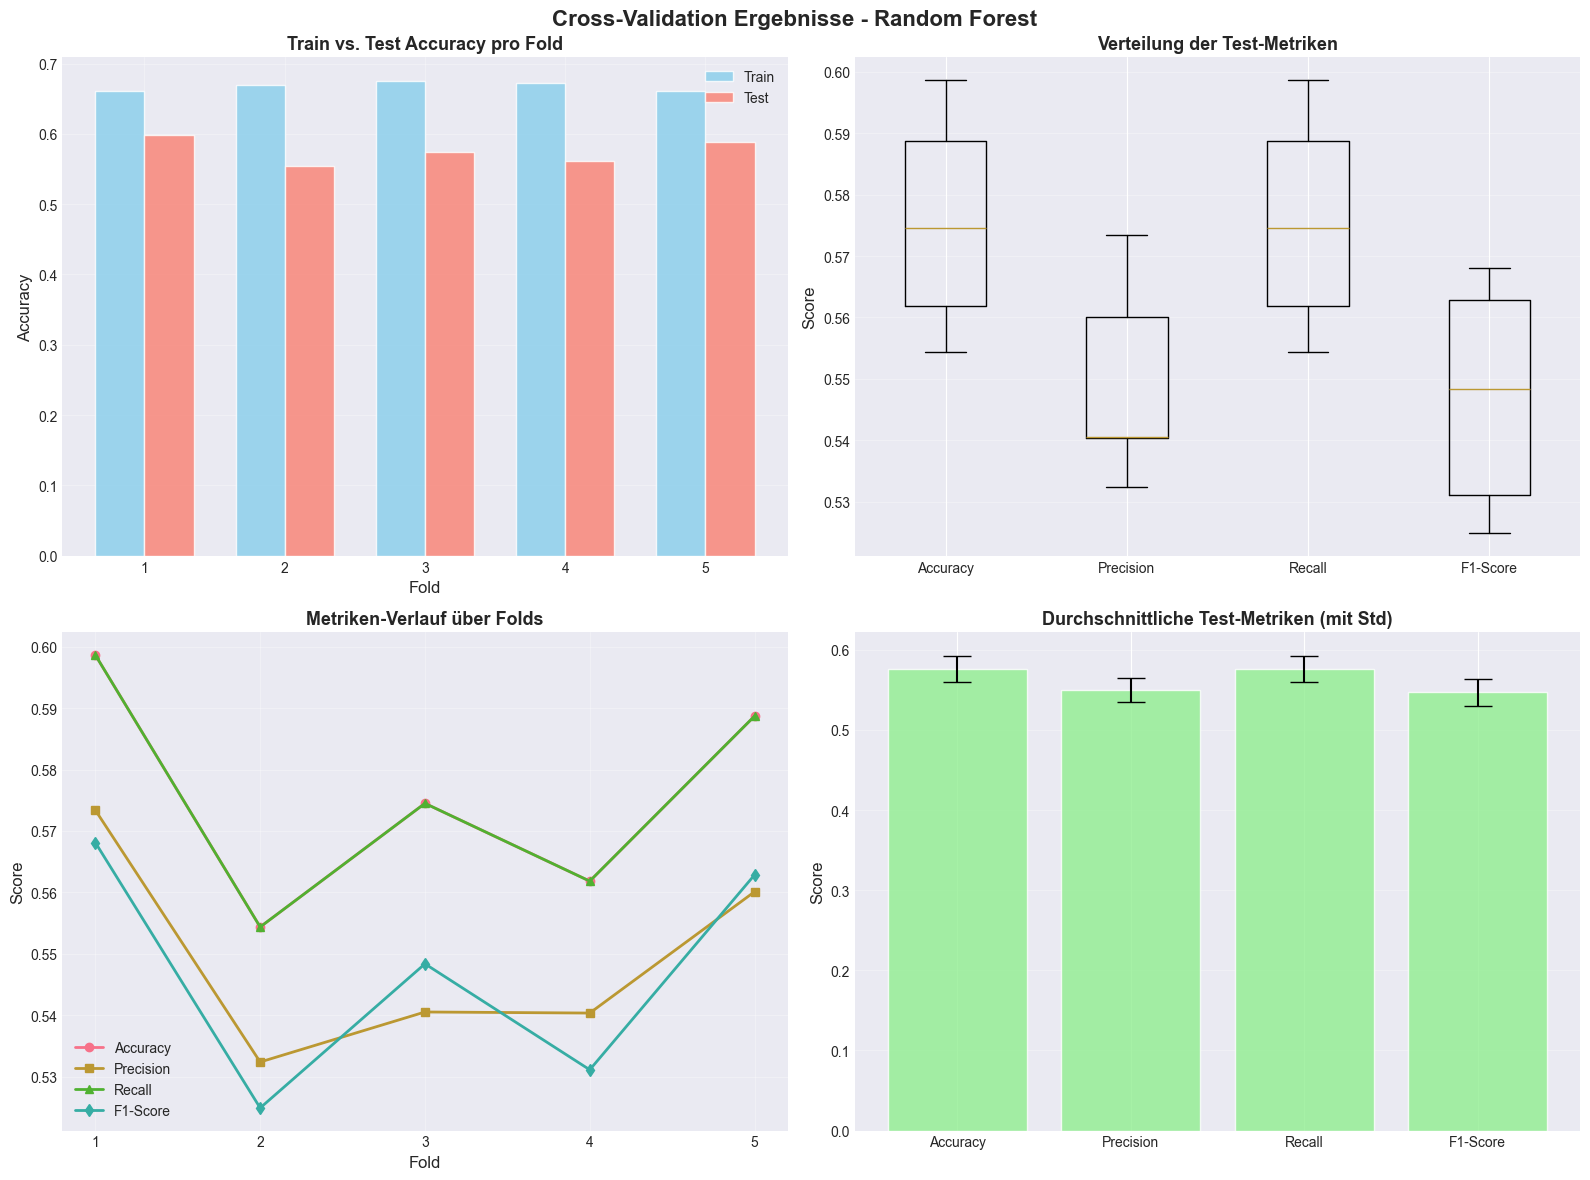

✓ Visualisierung gespeichert als 'figures/figure_cv_analysis.png'


In [14]:
# Visualize Cross-Validation Results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Validation Ergebnisse - Random Forest', fontsize=16, fontweight='bold')

# 1. Train vs Test Accuracy per Fold
ax1 = axes[0, 0]
x = cv_results_df['Fold']
width = 0.35
ax1.bar(x - width/2, cv_results_df['Train Accuracy'], width, label='Train', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, cv_results_df['Test Accuracy'], width, label='Test', alpha=0.8, color='salmon')
ax1.set_xlabel('Fold', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Train vs. Test Accuracy pro Fold', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(x)

# 2. Box Plot of all metrics
ax2 = axes[0, 1]
metrics_data = [cv_results['test_accuracy'],
                cv_results['test_precision_weighted'],
                cv_results['test_recall_weighted'],
                cv_results['test_f1_weighted']]
ax2.boxplot(metrics_data, labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Verteilung der Test-Metriken', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Line plot showing progression across folds
ax3 = axes[1, 0]
ax3.plot(cv_results_df['Fold'], cv_results_df['Test Accuracy'], marker='o', label='Accuracy', linewidth=2)
ax3.plot(cv_results_df['Fold'], cv_results_df['Test Precision'], marker='s', label='Precision', linewidth=2)
ax3.plot(cv_results_df['Fold'], cv_results_df['Test Recall'], marker='^', label='Recall', linewidth=2)
ax3.plot(cv_results_df['Fold'], cv_results_df['Test F1-Score'], marker='d', label='F1-Score', linewidth=2)
ax3.set_xlabel('Fold', fontsize=12)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Metriken-Verlauf über Folds', fontsize=13, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(cv_results_df['Fold'])

# 4. Summary Bar Chart
ax4 = axes[1, 1]
summary_data = summary_stats[summary_stats['Metrik'].str.contains('Test')]
metrics_names = [m.replace('Test ', '') for m in summary_data['Metrik']]
means = summary_data['Mittelwert'].values
stds = summary_data['Std. Abweichung'].values
x_pos = np.arange(len(metrics_names))
ax4.bar(x_pos, means, yerr=stds, align='center', alpha=0.8, ecolor='black', capsize=10, color='lightgreen')
ax4.set_ylabel('Score', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics_names, rotation=0)
ax4.set_title('Durchschnittliche Test-Metriken (mit Std)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/figure_cv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualisierung gespeichert als 'figures/figure_cv_analysis.png'")

### 5.3 Feature Importance Visualisation

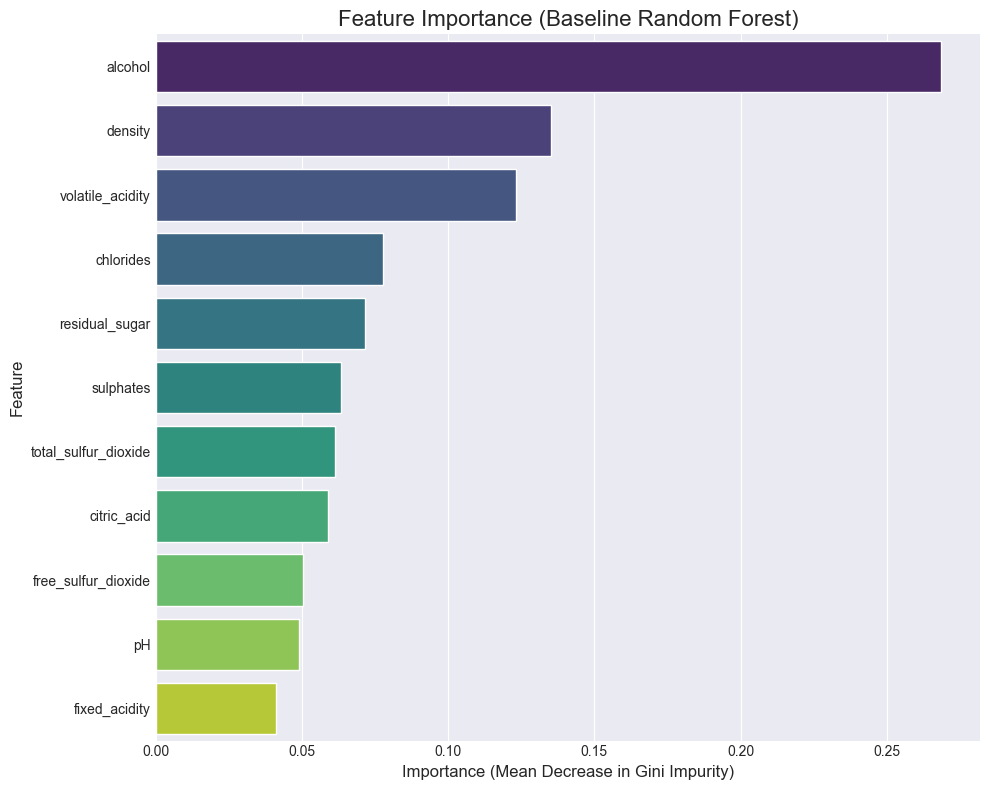


Top 11 Wichtigste Features:
                 Feature  Importance
10               alcohol    0.268474
7                density    0.135096
1       volatile_acidity    0.123185
4              chlorides    0.077610
3         residual_sugar    0.071692
9              sulphates    0.063323
6   total_sulfur_dioxide    0.061220
2            citric_acid    0.059090
5    free_sulfur_dioxide    0.050305
8                     pH    0.048893
0          fixed_acidity    0.041112


In [15]:
# 1. Feature Importance extrahieren
importances = baseline_model.feature_importances_

# 2. Feature-Namen holen
feature_names = X_train.columns

# 3. In einem DataFrame für einfaches Plotten kombinieren
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Nach Wichtigkeit sortieren
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 5. Visualisieren
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('Feature Importance (Baseline Random Forest)', fontsize=16)
plt.xlabel('Importance (Mean Decrease in Gini Impurity)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('figures/feature_importance_baselineRF.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 11 Wichtigste Features:")
print(feature_importance_df.head(11))

## 6. Feature Selection Methods <a id='feature-selection'></a>

In [16]:
feature_importance_results = {}

# 1. Correlation
correlation_scores = X_train_scaled.corrwith(y_train).abs()
feature_importance_results['Correlation'] = correlation_scores

# 2. Mutual Information
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)
feature_importance_results['Mutual Information'] = pd.Series(mi_scores, index=X_train.columns)

# 3. ANOVA F-test
f_scores, _ = f_classif(X_train_scaled, y_train)
feature_importance_results['ANOVA F-Score'] = pd.Series(f_scores, index=X_train.columns)

# 4. Tree Importance
tree_importance = pd.Series(baseline_model.feature_importances_, index=X_train.columns)
feature_importance_results['Tree Importance'] = tree_importance

# 5. Permutation Importance
perm_importance = permutation_importance(
    baseline_model, X_val_scaled, y_val,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
perm_scores = pd.Series(perm_importance.importances_mean, index=X_train.columns)
feature_importance_results['Permutation Importance'] = perm_scores

print("✓ Feature Selection Methods Complete (6 methods)")

✓ Feature Selection Methods Complete (6 methods)


In [17]:
# Compile and normalize
importance_df = pd.DataFrame(feature_importance_results)
importance_df_norm = importance_df.copy()

for col in importance_df_norm.columns:
    importance_df_norm[col] = (importance_df_norm[col] - importance_df_norm[col].min()) / \
                               (importance_df_norm[col].max() - importance_df_norm[col].min())

importance_df_norm['Average Score'] = importance_df_norm.mean(axis=1)
importance_df_norm['Rank'] = importance_df_norm['Average Score'].rank(ascending=False)
importance_df_norm = importance_df_norm.sort_values('Average Score', ascending=False)

print("\n" + "="*80)
print("TABLE 3: FEATURE IMPORTANCE RANKINGS")
print("="*80)
display(importance_df_norm.round(4))

importance_df_norm.to_csv('figures/table3_feature_importance_rankings.csv', sep=";")
print("\n✓ Saved to figures/table3_feature_importance_rankings.csv")


TABLE 3: FEATURE IMPORTANCE RANKINGS


,Correlation,Mutual Information,ANOVA F-Score,Tree Importance,Permutation Importance,Average Score,Rank
alcohol,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0
density,0.7115,0.9168,0.4713,0.4134,0.1652,0.5356,2.0
volatile_acidity,0.5468,0.2311,0.2613,0.3610,0.6031,0.4006,3.0
chlorides,0.5354,0.2802,0.2432,0.1605,0.1430,0.2725,4.0
total_sulfur_dioxide,0.0919,0.3967,0.0315,0.0884,0.1443,0.1506,5.0
residual_sugar,0.1013,0.3366,0.0320,0.1345,0.1034,0.1416,6.0
free_sulfur_dioxide,0.1405,0.2188,0.0509,0.0404,0.1305,0.1162,7.0
sulphates,0.1307,0.1236,0.0191,0.0977,0.1194,0.0981,8.0
citric_acid,0.1501,0.1240,0.0249,0.0791,0.0763,0.0909,9.0
fixed_acidity,0.1357,0.0000,0.0171,0.0000,0.0000,0.0305,10.0



✓ Saved to figures/table3_feature_importance_rankings.csv


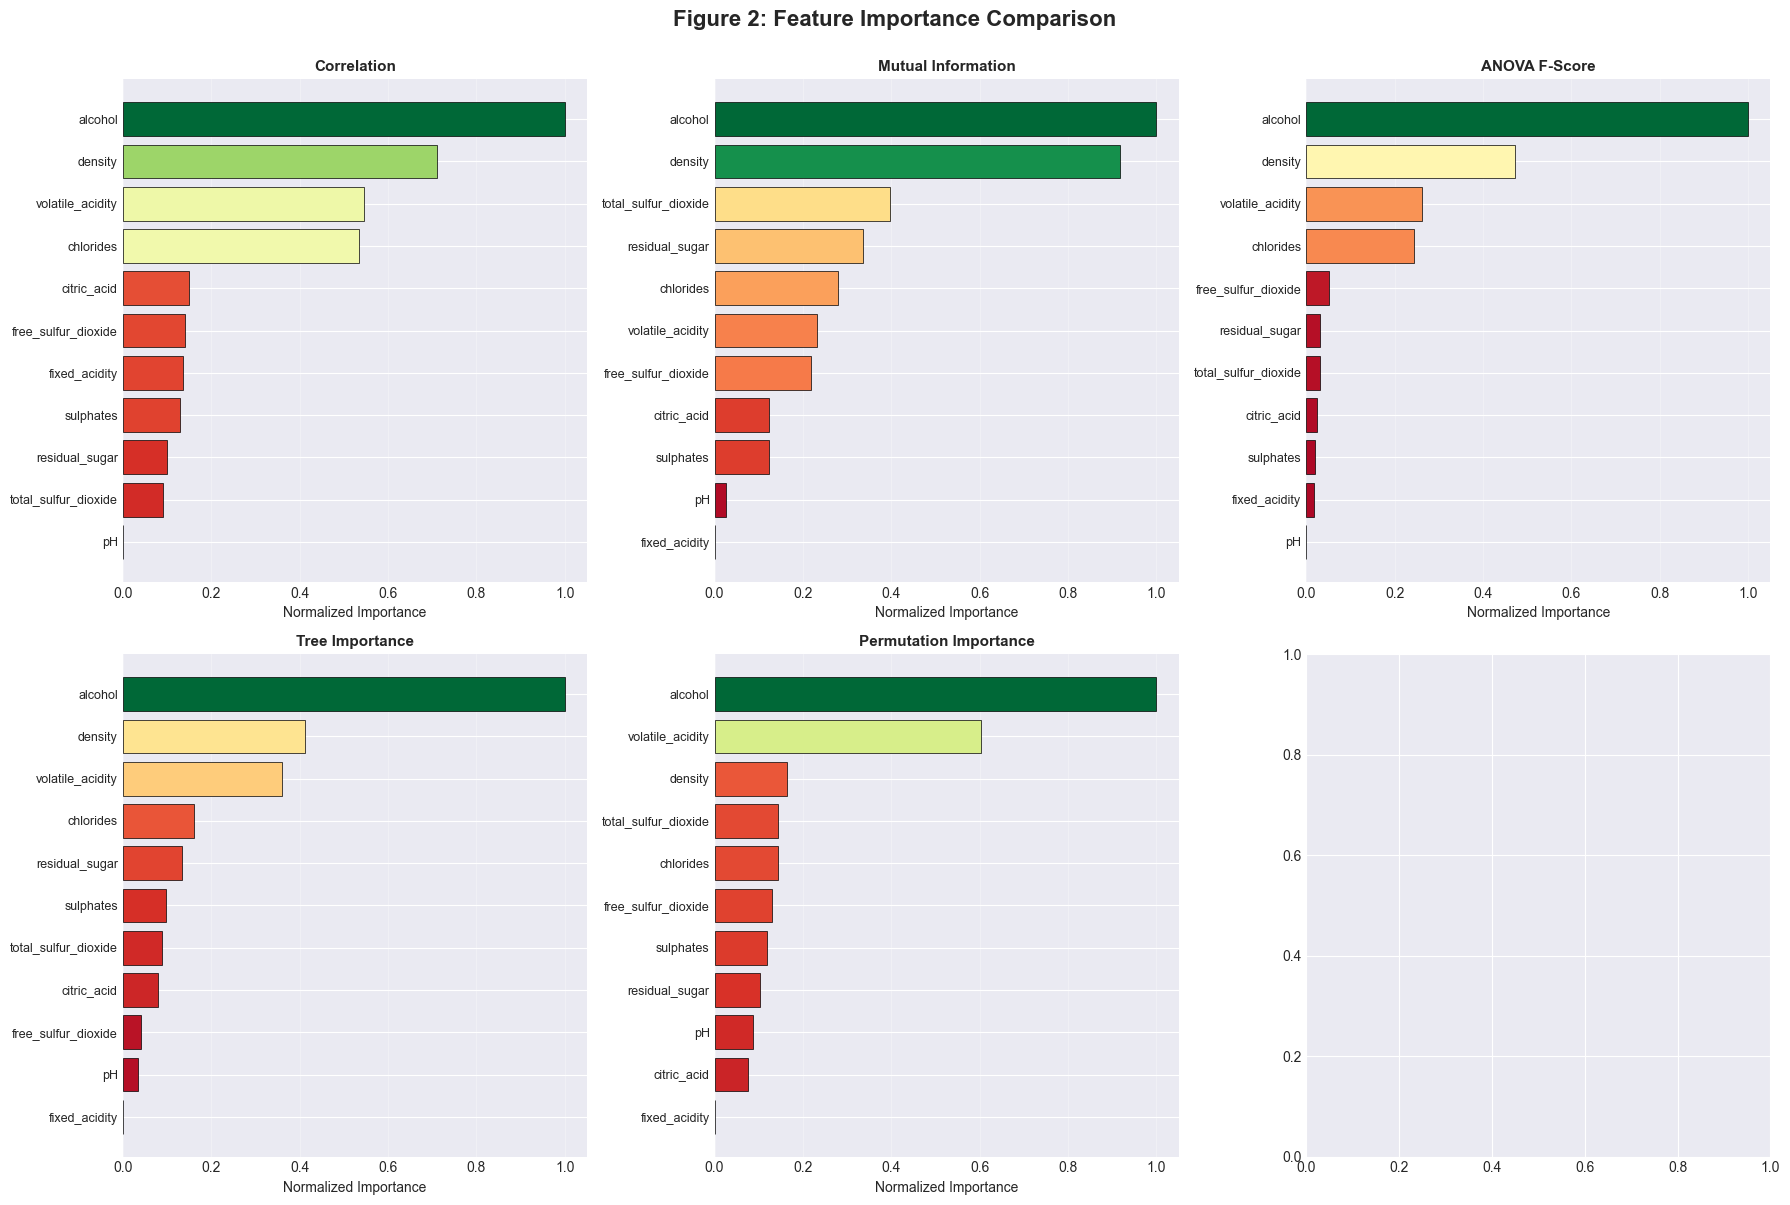

✓ Figure 2 saved


In [18]:
# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

methods = ['Correlation', 'Mutual Information', 'ANOVA F-Score', 
           'Tree Importance', 'Permutation Importance']

for idx, method in enumerate(methods):
    data = importance_df_norm[method].sort_values(ascending=True)
    colors = plt.cm.RdYlGn(data / data.max())
    axes[idx].barh(range(len(data)), data.values, color=colors, edgecolor='black', linewidth=0.5)
    axes[idx].set_yticks(range(len(data)))
    axes[idx].set_yticklabels(data.index, fontsize=9)
    axes[idx].set_xlabel('Normalized Importance', fontsize=10)
    axes[idx].set_title(method, fontsize=11, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Figure 2: Feature Importance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('figures/figure2_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved")

## 7. Ablation Study <a id='ablation'></a>

### 7.1 Individual Feature Ablation

In [19]:
ablation_results = []

print("Running Individual Feature Ablation (using VALIDATION set)...\n")

for feature in X_train.columns:
    features_subset = [f for f in X_train.columns if f != feature]
    X_train_ablated = X_train_scaled[features_subset]
    X_val_ablated = X_val_scaled[features_subset]
    
    model = RandomForestClassifier(**grid_search.best_params_)
    model.fit(X_train_ablated, y_train)
    
    y_val_pred = model.predict(X_val_ablated)
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_drop = baseline_metrics['Validation Accuracy'] - accuracy
    
    ablation_results.append({
        'Feature Removed': feature,
        'Validation Accuracy': accuracy,
        'Accuracy Drop': accuracy_drop,
        'Drop %': accuracy_drop / baseline_metrics['Validation Accuracy'] * 100
    })
    
    print(f"  Removed '{feature}': Acc={accuracy:.4f}, Drop={accuracy_drop:+.4f}")

ablation_df = pd.DataFrame(ablation_results).sort_values('Accuracy Drop', ascending=False)

print("\n" + "="*80)
print("TABLE 4: INDIVIDUAL FEATURE ABLATION RESULTS")
print("="*80)
display(ablation_df)

ablation_df.to_csv('figures/table4_ablation_results.csv', index=False, sep=";")
print("\n✓ Saved to figures/table4_ablation_results.csv")


Running Individual Feature Ablation (using VALIDATION set)...

  Removed 'fixed_acidity': Acc=0.6060, Drop=-0.0008
  Removed 'volatile_acidity': Acc=0.5743, Drop=+0.0309
  Removed 'citric_acid': Acc=0.5946, Drop=+0.0106
  Removed 'residual_sugar': Acc=0.5971, Drop=+0.0081
  Removed 'chlorides': Acc=0.5825, Drop=+0.0227
  Removed 'free_sulfur_dioxide': Acc=0.5857, Drop=+0.0195
  Removed 'total_sulfur_dioxide': Acc=0.5898, Drop=+0.0154
  Removed 'density': Acc=0.5963, Drop=+0.0089
  Removed 'pH': Acc=0.5906, Drop=+0.0146
  Removed 'sulphates': Acc=0.5865, Drop=+0.0187
  Removed 'alcohol': Acc=0.5825, Drop=+0.0227

TABLE 4: INDIVIDUAL FEATURE ABLATION RESULTS


,Feature Removed,Validation Accuracy,Accuracy Drop,Drop %
1,volatile_acidity,0.574330,0.030869,5.100671
4,chlorides,0.582453,0.022746,3.758389
10,alcohol,0.582453,0.022746,3.758389
5,free_sulfur_dioxide,0.585703,0.019496,3.221477
9,sulphates,0.586515,0.018684,3.087248
6,total_sulfur_dioxide,0.589764,0.015435,2.550336
8,pH,0.590577,0.014622,2.416107
2,citric_acid,0.594639,0.010561,1.744966
7,density,0.596263,0.008936,1.476510
3,residual_sugar,0.597076,0.008123,1.342282



✓ Saved to figures/table4_ablation_results.csv


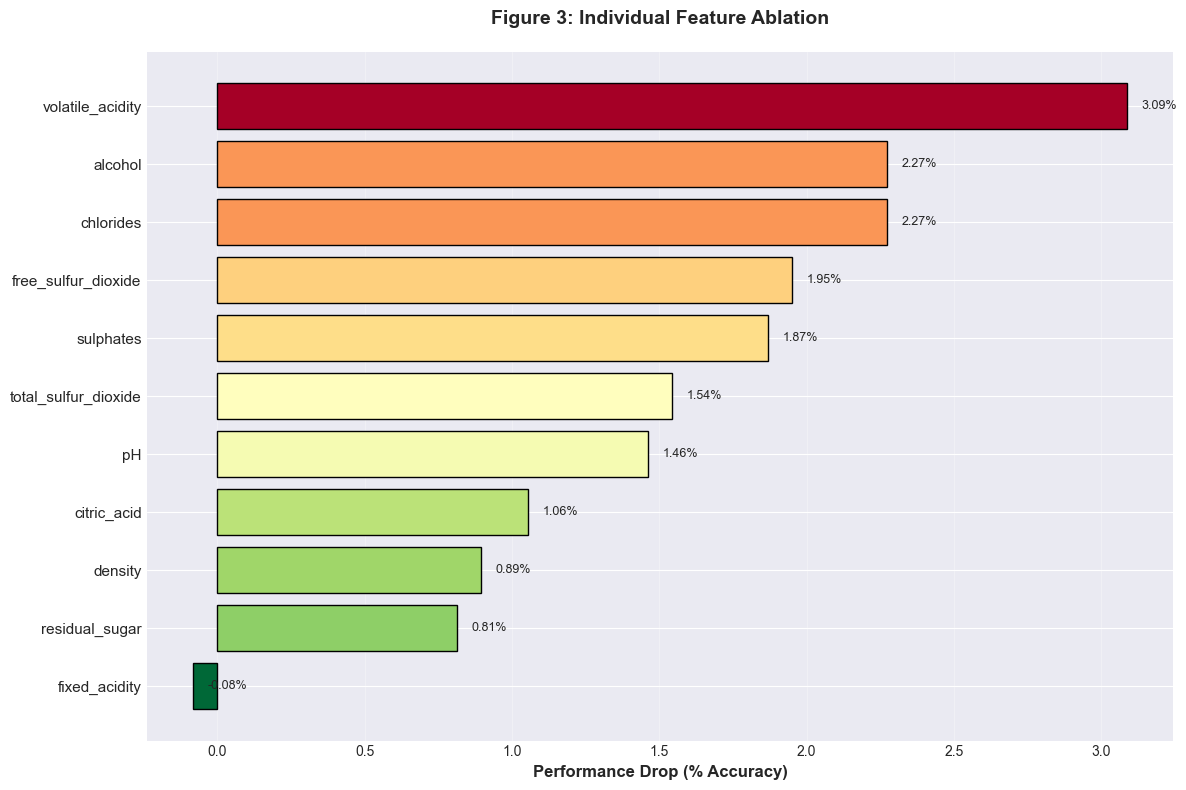

✓ Figure 3 saved


In [20]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
plot_data = ablation_df.sort_values('Accuracy Drop', ascending=True)
colors = plt.cm.RdYlGn_r(plot_data['Accuracy Drop'] / plot_data['Accuracy Drop'].max())

ax.barh(range(len(plot_data)), plot_data['Accuracy Drop'].values * 100,
        color=colors, edgecolor='black', linewidth=1)
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['Feature Removed'], fontsize=11)
ax.set_xlabel('Performance Drop (% Accuracy)', fontsize=12, fontweight='bold')
ax.set_title('Figure 3: Individual Feature Ablation', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(plot_data.iterrows()):
    value = row['Accuracy Drop'] * 100
    ax.text(value + 0.05, i, f"{value:.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/figure3_individual_ablation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved")

### 7.2 Cumulative Feature Addition

In [21]:
feature_order = importance_df_norm['Average Score'].sort_values(ascending=False).index.tolist()
cumulative_results = []

print("Running Cumulative Feature Addition...\n")

for i in range(1, len(feature_order) + 1):
    selected_features = feature_order[:i]
    X_train_subset = X_train_scaled[selected_features]
    X_val_subset = X_val_scaled[selected_features]
    
    model = RandomForestClassifier(**grid_search.best_params_)
    model.fit(X_train_subset, y_train)
    
    y_val_pred = model.predict(X_val_subset)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    cv_scores = cross_val_score(model, X_train_subset, y_train, cv=CV_FOLDS, scoring='accuracy')
    
    cumulative_results.append({
        'Num Features': i,
        'Validation Accuracy': accuracy,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    print(f"Top {i:2d}: Val Acc = {accuracy:.4f}")

# DataFrame erstellen
cumulative_df = pd.DataFrame(cumulative_results)

# Als CSV speichern mit Semikolon als Trennzeichen
cumulative_df.to_csv('figures/cumulative_feature_results.csv', sep=';', index=False, decimal=',')

print(f"\nPeak: {cumulative_df.loc[cumulative_df['Validation Accuracy'].idxmax(), 'Num Features']} features")
print(f"\nErgebnisse wurden gespeichert in: cumulative_feature_results.csv")

Running Cumulative Feature Addition...

Top  1: Val Acc = 0.5045
Top  2: Val Acc = 0.5207
Top  3: Val Acc = 0.5573
Top  4: Val Acc = 0.5613
Top  5: Val Acc = 0.5849
Top  6: Val Acc = 0.5768
Top  7: Val Acc = 0.5808
Top  8: Val Acc = 0.5890
Top  9: Val Acc = 0.5881
Top 10: Val Acc = 0.5890
Top 11: Val Acc = 0.5995

Peak: 11 features

Ergebnisse wurden gespeichert in: cumulative_feature_results.csv


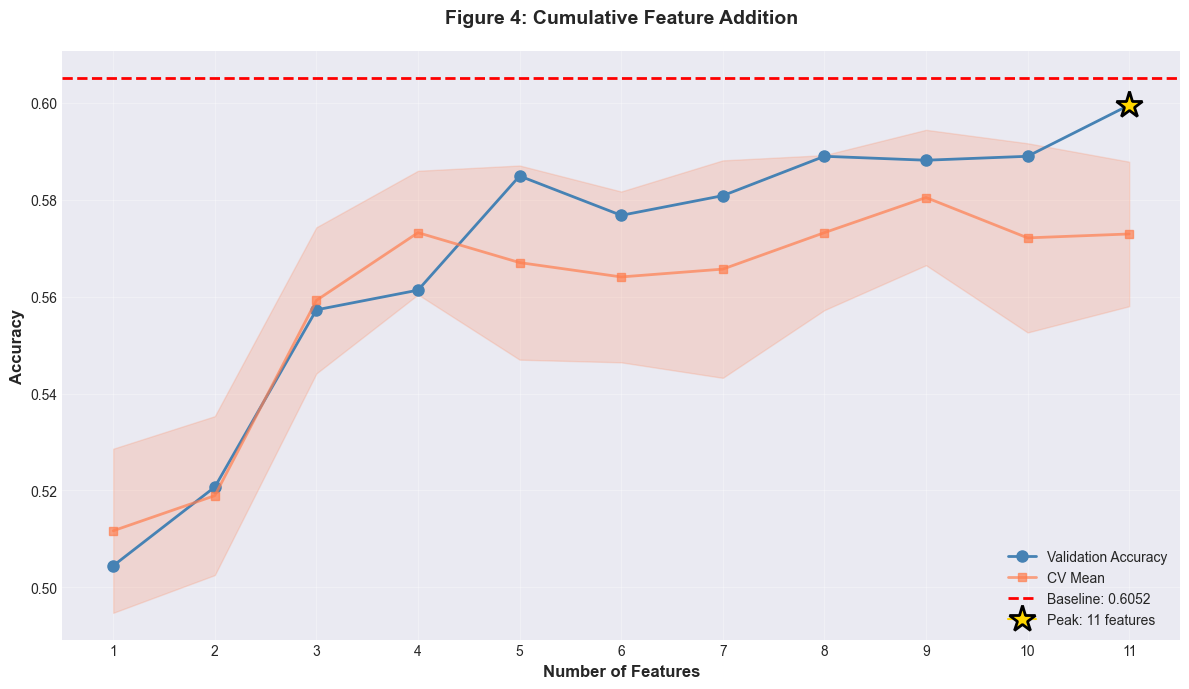

✓ Figure 4 saved


In [22]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(cumulative_df['Num Features'], cumulative_df['Validation Accuracy'], 
        marker='o', linewidth=2, markersize=8, color='steelblue', label='Validation Accuracy')
ax.plot(cumulative_df['Num Features'], cumulative_df['CV Mean'], 
        marker='s', linewidth=2, markersize=6, color='coral', label='CV Mean', alpha=0.7)

ax.fill_between(cumulative_df['Num Features'], 
                cumulative_df['CV Mean'] - cumulative_df['CV Std'],
                cumulative_df['CV Mean'] + cumulative_df['CV Std'],
                alpha=0.2, color='coral')

ax.axhline(y=baseline_metrics['Validation Accuracy'], color='red', linestyle='--', 
           linewidth=2, label=f"Baseline: {baseline_metrics['Validation Accuracy']:.4f}")

max_idx = cumulative_df['Validation Accuracy'].idxmax()
ax.plot(cumulative_df.loc[max_idx, 'Num Features'], 
        cumulative_df.loc[max_idx, 'Validation Accuracy'],
        marker='*', markersize=20, color='gold', 
        markeredgecolor='black', markeredgewidth=2,
        label=f"Peak: {cumulative_df.loc[max_idx, 'Num Features']} features")

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Figure 4: Cumulative Feature Addition', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, len(feature_order) + 1))

plt.tight_layout()
plt.savefig('figures/figure4_cumulative_addition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 4 saved")

### 7.3 Feature Group Ablation

Running Feature Group Ablation (using CV on Training set)...\n
Baseline CV Accuracy (Alle Features): 0.5780\n
  Removed 'acidity' (4 features): New CV Acc=0.5611, Drop=+0.0169
  Removed 'sulfur' (3 features): New CV Acc=0.5692, Drop=+0.0089
  Removed 'content' (3 features): New CV Acc=0.5565, Drop=+0.0215
  Removed 'physical' (1 features): New CV Acc=0.5847, Drop=-0.0067

TABLE 6: FEATURE GROUP ABLATION RESULTS (Sorted by Drop)


,Group Removed,Num Features Removed,CV Accuracy (Ablated),Performance Drop
2,content,3,0.556546,0.021482
0,acidity,4,0.561110,0.016919
1,sulfur,3,0.569165,0.008863
3,physical,1,0.584747,-0.006719



✓ Saved to figures/table6_group_ablation_results.csv


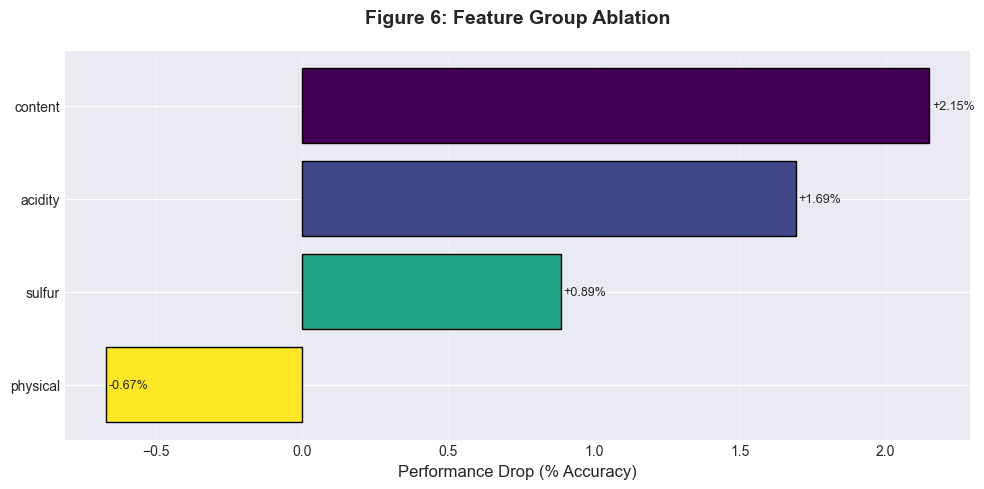


✓ Figure 6 saved


In [23]:
# --- 7.3 Feature Group Ablation ---

print("Running Feature Group Ablation (using CV on Training set)...\\n")

# 1. Feature-Gruppen definieren (basierend auf den Spaltennamen)
feature_groups = {
    'acidity': ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'pH'],
    'sulfur': ['free_sulfur_dioxide', 'total_sulfur_dioxide', 'sulphates'],
    'content': ['residual_sugar', 'chlorides', 'alcohol'],
    'physical': ['density']
}

# 2. Baseline-Score aus Zelle 60 abrufen (CV Mean ist der korrekte Vergleichswert)
baseline_cv_score = baseline_metrics['CV Mean']
print(f"Baseline CV Accuracy (Alle Features): {baseline_cv_score:.4f}\\n")

group_ablation_results = []

# 3. Ablation Study für Gruppen durchführen
for group_name, group_features in feature_groups.items():

    # WICHTIG: Skalierte Daten verwenden (X_train_scaled)
    X_train_ablated = X_train_scaled.drop(columns=group_features)

    # Verwenden Sie das optimierte baseline_model und die CV_FOLDS Variable
    scores = cross_val_score(baseline_model,
                             X_train_ablated,
                             y_train,
                             cv=CV_FOLDS,
                             scoring='accuracy')

    current_score = scores.mean()
    performance_drop = baseline_cv_score - current_score

    group_ablation_results.append({
        'Group Removed': group_name,
        'Num Features Removed': len(group_features),
        'CV Accuracy (Ablated)': current_score,
        'Performance Drop': performance_drop
    })

    print(f"  Removed '{group_name}' ({len(group_features)} features): New CV Acc={current_score:.4f}, Drop={performance_drop:+.4f}")

# 4. Ergebnisse anzeigen und speichern (wird Tabelle 6)
group_ablation_df = pd.DataFrame(group_ablation_results).sort_values('Performance Drop', ascending=False)

print("\n" + "="*80)
print("TABLE 6: FEATURE GROUP ABLATION RESULTS (Sorted by Drop)")
print("="*80)
display(group_ablation_df)

group_ablation_df.to_csv('figures/table6_group_ablation_results.csv', index=False, sep=";")
print("\n✓ Saved to figures/table6_group_ablation_results.csv")

# 5. Visualisierung (wird Abbildung 6)
fig, ax = plt.subplots(figsize=(10, 5))
plot_data_group = group_ablation_df.sort_values('Performance Drop', ascending=True)

# Performance-Abfall farblich kodieren
colors = plt.cm.viridis_r(plot_data_group['Performance Drop'] / plot_data_group['Performance Drop'].max())

ax.barh(plot_data_group['Group Removed'], plot_data_group['Performance Drop'] * 100,
        color=colors, edgecolor='black', linewidth=1)
ax.set_xlabel('Performance Drop (% Accuracy)', fontsize=12)
ax.set_title('Figure 6: Feature Group Ablation', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(plot_data_group.iterrows()):
    value = row['Performance Drop'] * 100
    ax.text(value + 0.01, i, f"{value:+.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/figure6_group_ablation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure 6 saved")

### 7.4 Top-K Feature Selection

In [24]:
k_values = [3, 5, 7, 9, 11]
topk_results = []

print("Testing Top-K Feature Selection...\n")

for k in k_values:
    top_features = feature_order[:k]
    X_train_k = X_train_scaled[top_features]
    X_val_k = X_val_scaled[top_features]
    
    model = RandomForestClassifier(**grid_search.best_params_)
    model.fit(X_train_k, y_train)
    
    y_val_pred = model.predict(X_val_k)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    complexity_reduction = (1 - k / len(feature_order)) * 100
    performance_retention = (accuracy / baseline_metrics['Validation Accuracy']) * 100
    
    topk_results.append({
        'K': k,
        'Validation Accuracy': accuracy,
        'Complexity Reduction %': complexity_reduction,
        'Performance Retention %': performance_retention
    })
    
    print(f"Top-{k}: Acc={accuracy:.4f}, Retention={performance_retention:.1f}%")

topk_df = pd.DataFrame(topk_results)

print("\n" + "="*80)
print("TABLE 5: TOP-K PERFORMANCE")
print("="*80)
display(topk_df)

topk_df.to_csv('figures/table5_topk_performance.csv', index=False, sep=";")
print("\n✓ Saved to figures/table5_topk_performance.csv")

Testing Top-K Feature Selection...

Top-3: Acc=0.5565, Retention=91.9%
Top-5: Acc=0.5914, Retention=97.7%
Top-7: Acc=0.5906, Retention=97.6%
Top-9: Acc=0.5849, Retention=96.6%
Top-11: Acc=0.5971, Retention=98.7%

TABLE 5: TOP-K PERFORMANCE


,K,Validation Accuracy,Complexity Reduction %,Performance Retention %
0,3,0.556458,72.727273,91.946309
1,5,0.591389,54.545455,97.718121
2,7,0.590577,36.363636,97.583893
3,9,0.584890,18.181818,96.644295
4,11,0.597076,0.000000,98.657718



✓ Saved to figures/table5_topk_performance.csv


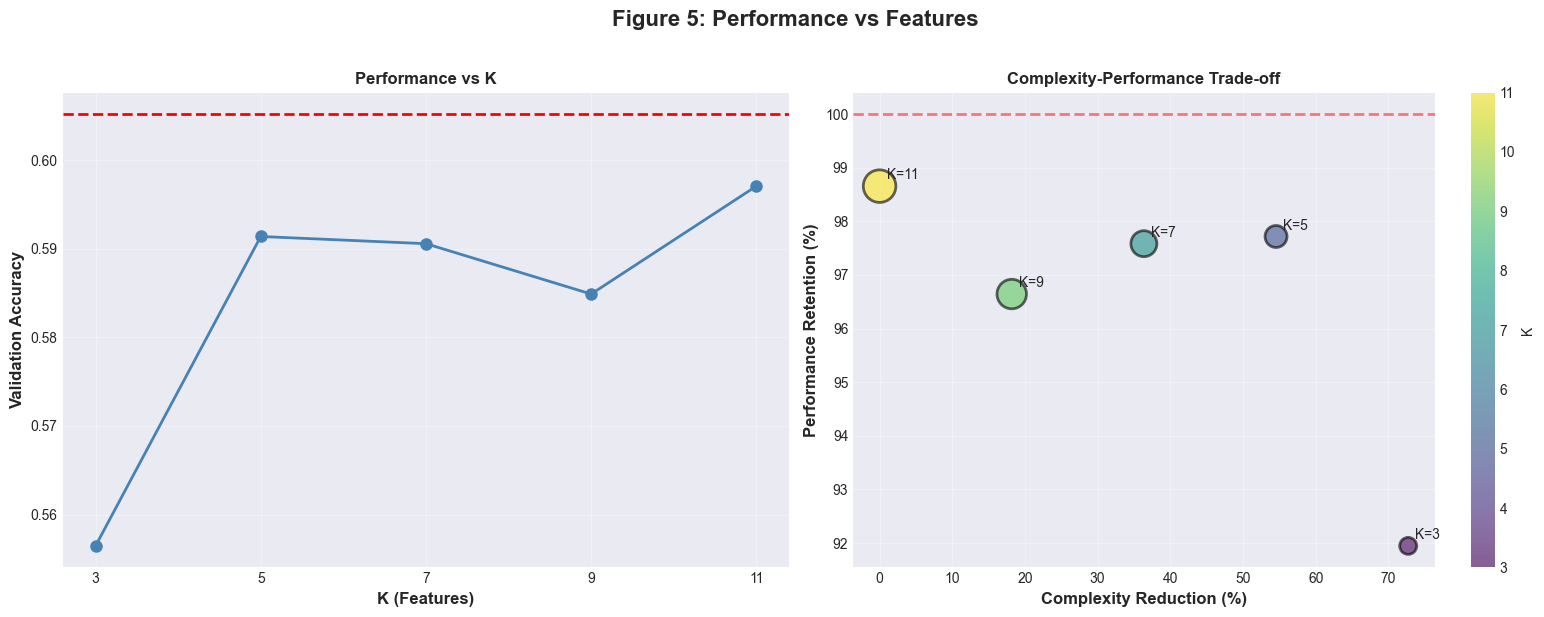

✓ Figure 5 saved


In [25]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(topk_df['K'], topk_df['Validation Accuracy'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(y=baseline_metrics['Validation Accuracy'], color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('K (Features)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Performance vs K', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(topk_df['K'])

scatter = axes[1].scatter(topk_df['Complexity Reduction %'], 
                          topk_df['Performance Retention %'],
                          s=topk_df['K']*50, alpha=0.6, c=topk_df['K'], 
                          cmap='viridis', edgecolors='black', linewidth=2)

for _, row in topk_df.iterrows():
    axes[1].annotate(f"K={int(row['K'])}", 
                     xy=(row['Complexity Reduction %'], row['Performance Retention %']),
                     xytext=(5, 5), textcoords='offset points')

axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('Complexity Reduction (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Performance Retention (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Complexity-Performance Trade-off', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes[1], label='K')
plt.suptitle('Figure 5: Performance vs Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/figure5_performance_vs_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 5 saved")

### 7.4 Final Test Set Evaluation

In [26]:
print("="*80)
print("FINAL TEST SET EVALUATION (Unbiased)")
print("="*80)

optimal_k = cumulative_df.loc[cumulative_df['Validation Accuracy'].idxmax(), 'Num Features']
optimal_features = feature_order[:optimal_k]

print(f"\nOptimal: {optimal_k} features - {', '.join(optimal_features)}\n")

test_evaluations = []

# 1. Baseline (all features)
test_evaluations.append({
    'Configuration': 'All Features',
    'Num Features': 11,
    'Test Accuracy': baseline_metrics['Test Accuracy'],
    'Test F1': baseline_metrics['Test F1']
})

# 2. Optimal subset
model_optimal = RandomForestClassifier(**grid_search.best_params_)
model_optimal.fit(X_train_scaled[optimal_features], y_train)
y_test_pred_opt = model_optimal.predict(X_test_scaled[optimal_features])

test_evaluations.append({
    'Configuration': f'Optimal ({optimal_k})',
    'Num Features': optimal_k,
    'Test Accuracy': accuracy_score(y_test, y_test_pred_opt),
    'Test F1': f1_score(y_test, y_test_pred_opt, average='weighted')
})

# 3. Top-5
model_top5 = RandomForestClassifier(**grid_search.best_params_)
model_top5.fit(X_train_scaled[feature_order[:5]], y_train)
y_test_pred_5 = model_top5.predict(X_test_scaled[feature_order[:5]])

test_evaluations.append({
    'Configuration': 'Top-5',
    'Num Features': 5,
    'Test Accuracy': accuracy_score(y_test, y_test_pred_5),
    'Test F1': f1_score(y_test, y_test_pred_5, average='weighted')
})

test_results_df = pd.DataFrame(test_evaluations)
display(test_results_df)

test_results_df.to_csv('figures/final_test_evaluation.csv', index=False, sep=";")
print("\n✓ Saved to figures/final_test_evaluation.csv")

FINAL TEST SET EVALUATION (Unbiased)

Optimal: 11 features - alcohol, density, volatile_acidity, chlorides, total_sulfur_dioxide, residual_sugar, free_sulfur_dioxide, sulphates, citric_acid, fixed_acidity, pH



,Configuration,Num Features,Test Accuracy,Test F1
0,All Features,11,0.586546,0.556953
1,Optimal (11),11,0.577523,0.545824
2,Top-5,5,0.566858,0.540983



✓ Saved to figures/final_test_evaluation.csv
